In [ ]:
# %pip install pyodbc python-dotenv

## Telco Churning Project using Machine Learning

This project will utilize the CRISP-DM framework for its analysis

## Business Understanding

Using the provided dataset, a business could gain insights into the factors that influence customer churn. For example, analyzing customer demographics (e.g., gender, SeniorCitizen status) could reveal if certain groups are more likely to churn, allowing the company to tailor retention efforts to those groups. Understanding the impact of services (e.g., PhoneService, InternetService) on churn could help in improving service quality or offering promotions to retain customers.

Furthermore, analyzing contract terms (e.g., Contract length, PaperlessBilling) and payment methods could provide insights into the effectiveness of different billing strategies in retaining customers. By identifying these factors and their impact on churn, businesses can develop targeted retention strategies, such as personalized offers, loyalty programs, or improved customer service, to reduce churn and increase customer loyalty.

Null Hypothesis 
- There is no significant relationship between the contract terms and customer churn.

Alternate Hypothesis
- There is a significant relationship between the contract terms and customer churn.

Analytical Questions
1. What is the total churn rate

2. What is the churn rate by gender?

3. How does the citizen level affect their likelihood to churn?

4. Are customers with PhoneService more likely to churn?

5. How do contract terms (e.g., Contract length, PaperlessBilling) influence churn?

6. What role do payment methods play in customer churn?

## Data Understanding

### Data Extraction

In [65]:
import pyodbc
from dotenv import dotenv_values
import pandas as pd
from scipy.stats import pearsonr, chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

# Machine learning packages
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
# Load environment variables from .env file into a dictionary
environment_variables = dotenv_values('.env')

# Get the values for the credentials you set in the '.env' file
server = environment_variables.get("SERVER")
database = environment_variables.get("DATABASE")
username = environment_variables.get("USERNAME")
password = environment_variables.get("PASSWORD")

connection_string = f"DRIVER={{ODBC Driver 18 for SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password};MARS_Connection=yes;MinProtocolVersion=TLSv1.2;"

In [4]:
connection = pyodbc.connect(connection_string)


In [5]:
query = "Select * from dbo.LP2_Telco_churn_first_3000"

data_set1 = pd.read_sql(query, connection)

In [6]:
data_set1.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,False,True,False,1,False,None,DSL,False,True,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000,False
1,5575-GNVDE,Male,False,False,False,34,True,False,DSL,True,False,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000,False
2,3668-QPYBK,Male,False,False,False,2,True,False,DSL,True,True,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,False,False,False,45,False,None,DSL,True,False,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.750000,False
4,9237-HQITU,Female,False,False,False,2,True,False,Fiber optic,False,False,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True


In [7]:
data_set2 = pd.read_csv('Data\LP2_Telco-churn-second-2000.csv')

data_set2.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5600-PDUJF,Male,0,No,No,6,Yes,No,DSL,No,No,No,Yes,No,No,Month-to-month,Yes,Credit card (automatic),49.50,312.7,No
1,8292-TYSPY,Male,0,No,No,19,Yes,No,DSL,No,No,Yes,Yes,No,No,Month-to-month,Yes,Credit card (automatic),55.00,1046.5,Yes
2,0567-XRHCU,Female,0,Yes,Yes,69,No,No phone service,DSL,Yes,No,Yes,No,No,Yes,Two year,Yes,Credit card (automatic),43.95,2960.1,No
3,1867-BDVFH,Male,0,Yes,Yes,11,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,74.35,834.2,Yes
4,2067-QYTCF,Female,0,Yes,No,64,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,111.15,6953.4,No


In [8]:
df_test = pd.read_excel('Data\Telco-churn-last-2000.xlsx')

df_test.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7613-LLQFO,Male,0,No,No,12,Yes,Yes,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,84.45,1059.55
1,4568-TTZRT,Male,0,No,No,9,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.40,181.8
2,9513-DXHDA,Male,0,No,No,27,Yes,No,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,No,Electronic check,81.70,2212.55
3,2640-PMGFL,Male,0,No,Yes,27,Yes,Yes,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,79.50,2180.55
4,3801-HMYNL,Male,0,Yes,Yes,1,Yes,No,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,No,Mailed check,89.15,89.15


In [9]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        2000 non-null   object 
 1   gender            2000 non-null   object 
 2   SeniorCitizen     2000 non-null   int64  
 3   Partner           2000 non-null   object 
 4   Dependents        2000 non-null   object 
 5   tenure            2000 non-null   int64  
 6   PhoneService      2000 non-null   object 
 7   MultipleLines     2000 non-null   object 
 8   InternetService   2000 non-null   object 
 9   OnlineSecurity    2000 non-null   object 
 10  OnlineBackup      2000 non-null   object 
 11  DeviceProtection  2000 non-null   object 
 12  TechSupport       2000 non-null   object 
 13  StreamingTV       2000 non-null   object 
 14  StreamingMovies   2000 non-null   object 
 15  Contract          2000 non-null   object 
 16  PaperlessBilling  2000 non-null   object 


### Analyzing the Data

In [10]:
data_train = pd.concat([data_set1, data_set2],  axis=0  ,ignore_index=True)

data_train.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,True,False,1,False,None,DSL,False,True,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.85,False
1,5575-GNVDE,Male,0,False,False,34,True,False,DSL,True,False,True,False,False,False,One year,False,Mailed check,56.950001,1889.5,False
2,3668-QPYBK,Male,0,False,False,2,True,False,DSL,True,True,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,0,False,False,45,False,None,DSL,True,False,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.75,False
4,9237-HQITU,Female,0,False,False,2,True,False,Fiber optic,False,False,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True


In [11]:
data_train.shape


(5043, 21)

The first train dataset has data for 5043 customers. It's worth noting that the following columns have null values; multipleLines, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, TotalCharges, Churn

In [12]:
data_train.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,True,False,1,False,None,DSL,False,True,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.85,False
1,5575-GNVDE,Male,0,False,False,34,True,False,DSL,True,False,True,False,False,False,One year,False,Mailed check,56.950001,1889.5,False
2,3668-QPYBK,Male,0,False,False,2,True,False,DSL,True,True,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,0,False,False,45,False,None,DSL,True,False,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.75,False
4,9237-HQITU,Female,0,False,False,2,True,False,Fiber optic,False,False,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True


In [13]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5043 non-null   object 
 1   gender            5043 non-null   object 
 2   SeniorCitizen     5043 non-null   int64  
 3   Partner           5043 non-null   object 
 4   Dependents        5043 non-null   object 
 5   tenure            5043 non-null   int64  
 6   PhoneService      5043 non-null   object 
 7   MultipleLines     4774 non-null   object 
 8   InternetService   5043 non-null   object 
 9   OnlineSecurity    4392 non-null   object 
 10  OnlineBackup      4392 non-null   object 
 11  DeviceProtection  4392 non-null   object 
 12  TechSupport       4392 non-null   object 
 13  StreamingTV       4392 non-null   object 
 14  StreamingMovies   4392 non-null   object 
 15  Contract          5043 non-null   object 
 16  PaperlessBilling  5043 non-null   object 


Insights Derived

1. Dataset has 5034 entries
2. Dataset contains both object and int data types
3. Columns like OnlineSecurity, OnlineBackup, DeviceProtection<TechSupport, StreamingTv, and StreamingMovies have 651 null entries
4. Multiple lines has 269 null entries and churn has 1 null entry

## Check for missing values


In [14]:
#Check for missing values
data_train.isnull().sum()

customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          5
Churn                 1
dtype: int64

In [15]:
#find the percentage of missing values in each column
(data_train.isnull().sum()/(len(data_set1)))*100

customerID           0.000000
gender               0.000000
SeniorCitizen        0.000000
Partner              0.000000
Dependents           0.000000
tenure               0.000000
PhoneService         0.000000
MultipleLines        8.966667
InternetService      0.000000
OnlineSecurity      21.700000
OnlineBackup        21.700000
DeviceProtection    21.700000
TechSupport         21.700000
StreamingTV         21.700000
StreamingMovies     21.700000
Contract             0.000000
PaperlessBilling     0.000000
PaymentMethod        0.000000
MonthlyCharges       0.000000
TotalCharges         0.166667
Churn                0.033333
dtype: float64

In [16]:
#Fill the missing values in the Multplelines column with values in the Phoneservice column since its evident you can't have multiplelines without phoneservice

#First change the datatype for MultipleLines column to bool
data_train['MultipleLines'] = data_train['MultipleLines'].astype(bool)

#Fill missing values with the values from the phoneservice column

data_train['MultipleLines'] = data_train['MultipleLines'].fillna(data_train['PhoneService'])

In [17]:
#fill the missing values in the columns OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies with 'unknown'

data_train['OnlineSecurity'] = data_train['OnlineSecurity'].fillna('Unknown')
data_train['OnlineBackup'] = data_train['OnlineBackup'].fillna('Unknown')
data_train['DeviceProtection'] = data_train['DeviceProtection'].fillna('Unknown')
data_train['TechSupport'] = data_train['TechSupport'].fillna('Unknown')
data_train['StreamingTV'] = data_train['StreamingTV'].fillna('Unknown')
data_train['StreamingMovies'] = data_train['StreamingMovies'].fillna('Unknown')

In [18]:
# fil missing values in the totalCharges column with the median value

#first change data type to numeric
data_train['TotalCharges'] = pd.to_numeric(data_train['TotalCharges'], errors='coerce')


#find median value

median_value = data_train['TotalCharges'].median()

#fill the missing values
data_train['TotalCharges'] = data_train['TotalCharges'].fillna(median_value)

In [19]:
#Drop the row with the null value in the churn column since it is a target variable
data_train.dropna(subset='Churn', inplace=True)

## Check for Duplication


In [20]:
data_train.duplicated().sum()

0

There are no duplicates in the first train data

In [21]:
# Check for uniques value
data_train.nunique()

customerID          5042
gender                 2
SeniorCitizen          2
Partner                4
Dependents             4
tenure                73
PhoneService           4
MultipleLines          2
InternetService        3
OnlineSecurity         6
OnlineBackup           6
DeviceProtection       6
TechSupport            6
StreamingTV            6
StreamingMovies        6
Contract               3
PaperlessBilling       4
PaymentMethod          4
MonthlyCharges      2069
TotalCharges        4862
Churn                  4
dtype: int64

In [22]:

# Check for unique values
Columns = ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling','PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn' ]

final = []

for col in Columns:

    unique_values = data_train[col].unique()

    final.append([col, unique_values])

final_df = pd.DataFrame(final, columns=['Column', 'Unique_Values'])

final_df

,Column,Unique_Values
0,customerID,"[7590-VHVEG, 5575-GNVDE, 3668-QPYBK, 7795-CFOCW, 9237-HQITU, 9305-CDSKC, 1452-KIOVK, 6713-OKOMC, 7892-POOKP, 6388-TABGU, 9763-GRSKD, 7469-LKBCI, 8091-TTVAX, 0280-XJGEX, 5129-JLPIS, 3655-SNQYZ, 8191-XWSZG, 9959-WOFKT, 4190-MFLUW, 4183-MYFRB, 8779-QRDMV, 1680-VDCWW, 1066-JKSGK, 3638-WEABW, 6322-HRPFA, 6865-JZNKO, 6467-CHFZW, 8665-UTDHZ, 5248-YGIJN, 8773-HHUOZ, 3841-NFECX, 4929-XIHVW, 6827-IEAUQ, 7310-EGVHZ, 3413-BMNZE, 6234-RAAPL, 6047-YHPVI, 6572-ADKRS, 5380-WJKOV, 8168-UQWWF, 8865-TNMNX, 9489-DEDVP, 9867-JCZSP, 4671-VJLCL, 4080-IIARD, 3714-NTNFO, 5948-UJZLF, 7760-OYPDY, 7639-LIAYI, 2954-PIBKO, 8012-SOUDQ, 9420-LOJKX, 6575-SUVOI, 7495-OOKFY, 4667-QONEA, 1658-BYGOY, 8769-KKTPH, 5067-XJQFU, 3957-SQXML, 5954-BDFSG, 0434-CSFON, 1215-FIGMP, 0526-SXDJP, 0557-ASKVU, 5698-BQJOH, 5122-CYFXA, 8627-ZYGSZ, 3410-YOQBQ, 3170-NMYVV, 7410-OIEDU, 2273-QCKXA, 0731-EBJQB, 1891-QRQSA, 8028-PNXHQ, 5630-AHZIL, 2673-CXQEU, 6416-JNVRK, 5590-ZSKRV, 0191-ZHSKZ, 3887-PBQAO, 5919-TMRGD, 8108-UXRQN, 9191-MYQKX, 9919-YLNNG, 0318-ZOPWS, 4445-ZJNMU, 4808-YNLEU, 1862-QRWPE, 2796-NNUFI, 3016-KSVCP, 4767-HZZHQ, 2424-WVHPL, 7233-PAHHL, 6067-NGCEU, 9848-JQJTX, 8637-XJIVR, 9803-FTJCG, 0278-YXOOG, 3212-KXOCR, 4598-XLKNJ, ...]"
1,gender,"[Female, Male]"
2,SeniorCitizen,"[0, 1]"
3,Partner,"[True, False, No, Yes]"
4,Dependents,"[False, True, No, Yes]"
5,tenure,"[1, 34, 2, 45, 8, 22, 10, 28, 62, 13, 16, 58, 49, 25, 69, 52, 71, 21, 12, 30, 47, 72, 17, 27, 5, 46, 11, 70, 63, 43, 15, 60, 18, 66, 9, 3, 31, 50, 64, 56, 7, 42, 35, 48, 29, 65, 38, 68, 32, 55, 37, 36, 41, 6, 4, 33, 67, 23, 57, 61, 14, 20, 53, 40, 59, 24, 44, 19, 54, 51, 26, 0, 39]"
6,PhoneService,"[False, True, Yes, No]"
7,MultipleLines,"[False, True]"
8,InternetService,"[DSL, Fiber optic, No]"
9,OnlineSecurity,"[False, True, Unknown, No, Yes, No internet service]"


In [23]:
def map_to_boolean(df):
    df['Partner'] = df['Partner'].map({"Yes": True, "No": False})
    df['PhoneService'] = df['PhoneService'].map({"Yes": True, "No": False})
    df['Dependents'] = df['Dependents'].map({"Yes": True, "No": False})
    df['OnlineSecurity'] = df['OnlineSecurity'].map({"Yes": True, "No": False, "No internet service": False})
    df['OnlineBackup'] = df['OnlineBackup'].map({"Yes": True, "No": False, "No internet service": False})
    df['DeviceProtection'] = df['DeviceProtection'].map({"Yes": True, "No": False, "No internet service": False})
    df['TechSupport'] = df['TechSupport'].map({"Yes": True, "No": False, "No internet service": False})
    df['StreamingTV'] = df['StreamingTV'].map({"Yes": True, "No": False, "No internet service": False})
    df['StreamingMovies'] = df['StreamingMovies'].map({"Yes": True, "No": False, "No internet service": False})
    df['PaperlessBilling'] = df['PaperlessBilling'].map({"Yes": True, "No": False})
    df['Churn'] = df['Churn'].map({"Yes": True, "No": False})

    return df
#Map over df
data_train = map_to_boolean(data_train)

In [24]:
data_train['Partner'] = data_train['Partner'].astype(bool)
data_train['PhoneService'] = data_train['PhoneService'].astype(bool)
data_train['Dependents'] = data_train['Dependents'].astype(bool)
data_train['OnlineSecurity'] = data_train['OnlineSecurity'].astype(bool)
data_train['OnlineBackup'] = data_train['OnlineBackup'].astype(bool)
data_train['DeviceProtection'] = data_train['DeviceProtection'].astype(bool)
data_train['TechSupport'] = data_train['TechSupport'].astype(bool)
data_train['StreamingTV'] = data_train['StreamingTV'].astype(bool)
data_train['StreamingMovies'] = data_train['StreamingMovies'].astype(bool)
data_train['PaperlessBilling'] = data_train['PaperlessBilling'].astype(bool)
data_train['Churn'] = data_train['Churn'].astype(bool)

In [25]:
# Check for unique values
for column in data_train.columns:
    unique_entries = data_train[column].unique()
    print(f"Column '{column}' has {len(unique_entries)} unique entries:")
    print(unique_entries[:])
    print()

Column 'customerID' has 5042 unique entries:
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']

Column 'gender' has 2 unique entries:
['Female' 'Male']

Column 'SeniorCitizen' has 2 unique entries:
[0 1]

Column 'Partner' has 2 unique entries:
[ True False]

Column 'Dependents' has 2 unique entries:
[ True False]

Column 'tenure' has 73 unique entries:
[ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]

Column 'PhoneService' has 2 unique entries:
[ True False]

Column 'MultipleLines' has 2 unique entries:
[False  True]

Column 'InternetService' has 3 unique entries:
['DSL' 'Fiber optic' 'No']

Column 'OnlineSecurity' has 2 unique entries:
[ True False]

Column 'OnlineBackup' has 2 unique entries:
[ True False]

Column 'DeviceProtection' has 2 unique entries:
[ True False]

Column '

In [26]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5042 entries, 0 to 5042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5042 non-null   object 
 1   gender            5042 non-null   object 
 2   SeniorCitizen     5042 non-null   int64  
 3   Partner           5042 non-null   bool   
 4   Dependents        5042 non-null   bool   
 5   tenure            5042 non-null   int64  
 6   PhoneService      5042 non-null   bool   
 7   MultipleLines     5042 non-null   bool   
 8   InternetService   5042 non-null   object 
 9   OnlineSecurity    5042 non-null   bool   
 10  OnlineBackup      5042 non-null   bool   
 11  DeviceProtection  5042 non-null   bool   
 12  TechSupport       5042 non-null   bool   
 13  StreamingTV       5042 non-null   bool   
 14  StreamingMovies   5042 non-null   bool   
 15  Contract          5042 non-null   object 
 16  PaperlessBilling  5042 non-null   bool   
 17  

## Exploratory Data Analysis



In [27]:
data_train.describe(include='all')

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
count,5042,5042,5042.000000,5042,5042,5042.000000,5042,5042,5042,5042,5042,5042,5042,5042,5042,5042,5042,5042,5042.000000,5042.000000,5042
unique,5042,2,NaN,2,2,NaN,2,2,3,2,2,2,2,2,2,3,2,4,NaN,NaN,2
top,7590-VHVEG,Male,NaN,True,True,NaN,True,True,Fiber optic,True,True,True,True,True,True,Month-to-month,True,Electronic check,NaN,NaN,True
freq,1,2558,NaN,3995,3630,NaN,4822,3336,2247,3584,3702,3690,3617,3785,3782,2744,4219,1699,NaN,NaN,3555
mean,NaN,NaN,0.162436,NaN,NaN,32.568822,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.081376,2299.527063,NaN
std,NaN,NaN,0.368886,NaN,NaN,24.525954,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.064564,2266.828752,NaN
min,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.400000,18.799999,NaN
25%,NaN,NaN,0.000000,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.762500,417.875000,NaN
50%,NaN,NaN,0.000000,NaN,NaN,29.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.550003,1401.150024,NaN
75%,NaN,NaN,0.000000,NaN,NaN,56.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90.050002,3857.012573,NaN


### Observations

The dataset contains virtually an equal number of males and females, however males outnumber females by a margin of 75.

Most customers in the dataset are not senior citizens.

There appears to be more people in relationships than singles.

Most consumers have  dependents.

The average tenure is 32.53, with a median of 29.

The majority of clients are connected with numerous lines.

Most users use fibre optics for their internet connection.

Even though the majority of customers are linked to the internet, online security remains a significant threat.

Most people enjoy to streaming there movies and there favorite tv shows.

Customers also prefer to pay on a monthly basis

Most common method of payment method is through electronic checks

The average monthly charge is 65.09 with the min being 18.4 and max 118

The average total charge is NAN requiring a change of dtype from object to float








## Check for Skewness


In [28]:
#Check for Skewness

categorical_values = ['customerID', 'SeniorCitizen','gender', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']
categorical_values

['customerID',
 'SeniorCitizen',
 'gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'Churn']

In [29]:
data_train.drop(categorical_values, axis=1).skew()

tenure            0.225416
MonthlyCharges   -0.238663
TotalCharges      0.946402
dtype: float64

In [30]:
data_train.drop(categorical_values, axis=1).skew().sum()

0.9331545545748895

In [31]:
numerical_columns = ['tenure', 'MonthlyCharges', 'TotalCharges']
numerical_columns

['tenure', 'MonthlyCharges', 'TotalCharges']

## Check for Outliers

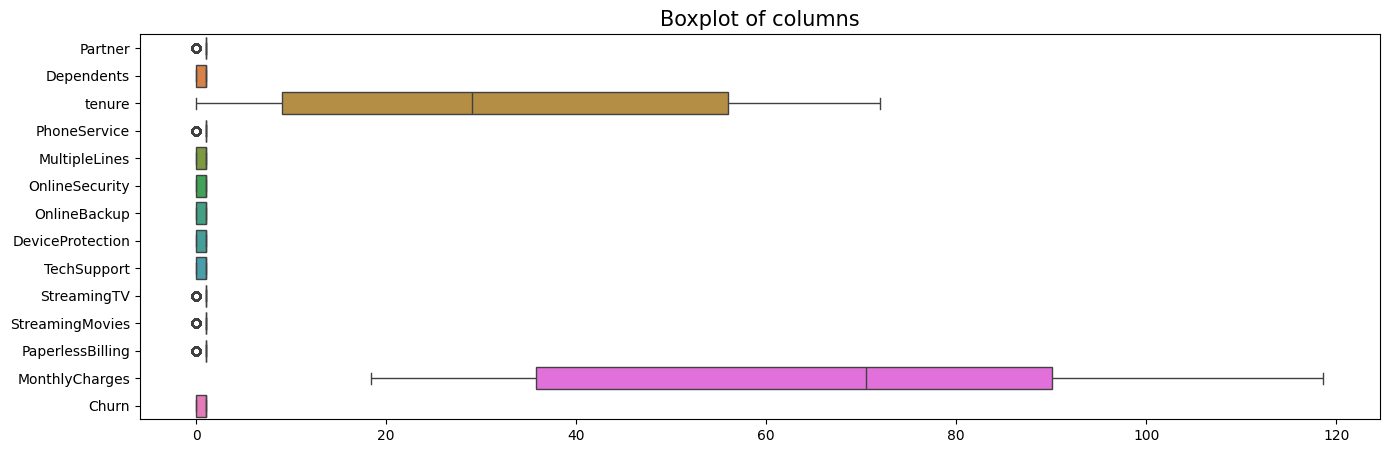

In [32]:
# Check for outliers
plt.figure(figsize=(16, 5))
sns.boxplot(data_train.drop(['TotalCharges', 'SeniorCitizen'], axis=1), orient = 'h')
plt.title('Boxplot of columns', fontsize=15)
plt.show()

### Check the distribution of the dataset

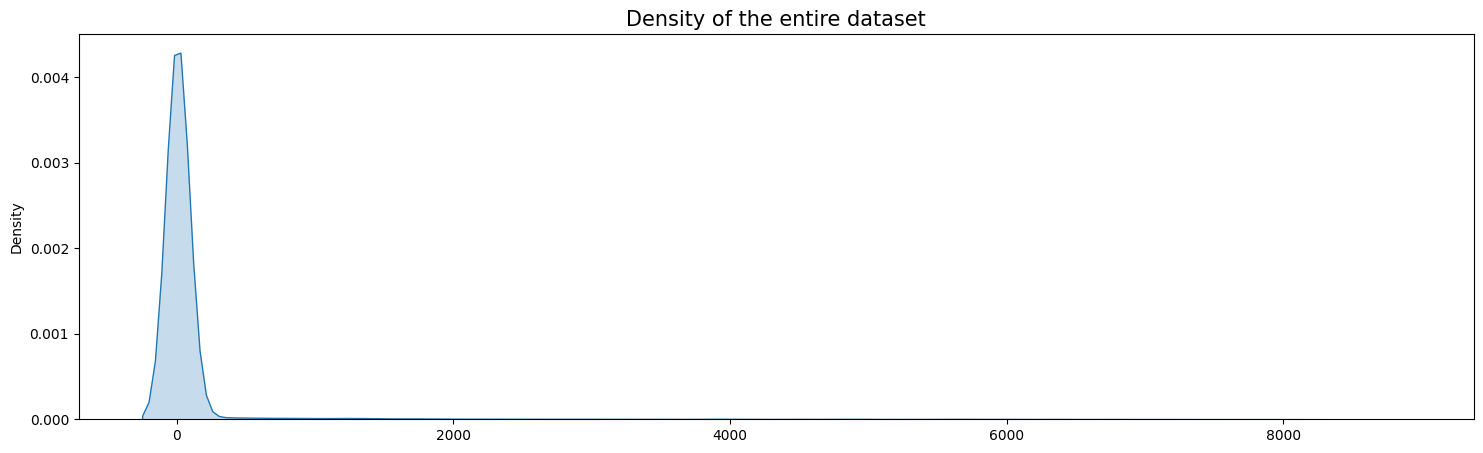

In [33]:
plt.figure(figsize=(18,5))
sns.kdeplot(data_train.drop(['customerID', 'gender', 'Contract', 'PaymentMethod', 'InternetService'], axis=1).values.ravel(), fill=True)
plt.title('Density of the entire dataset', fontsize=15)
plt.show()

## EDA Univariate Analysis

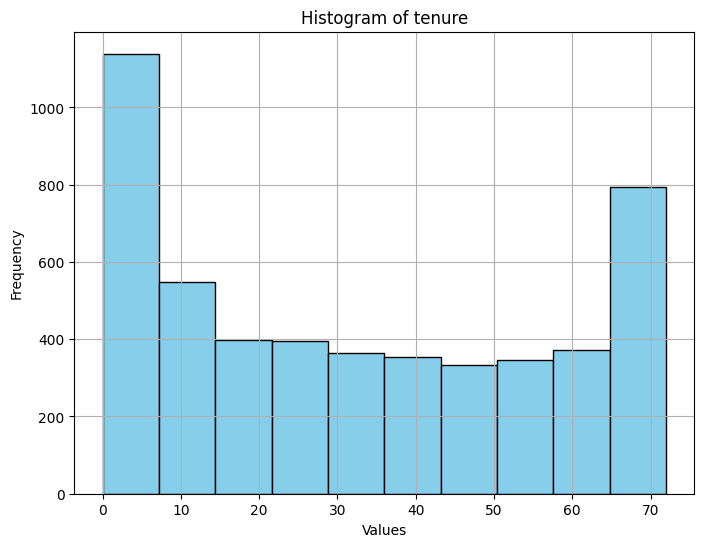

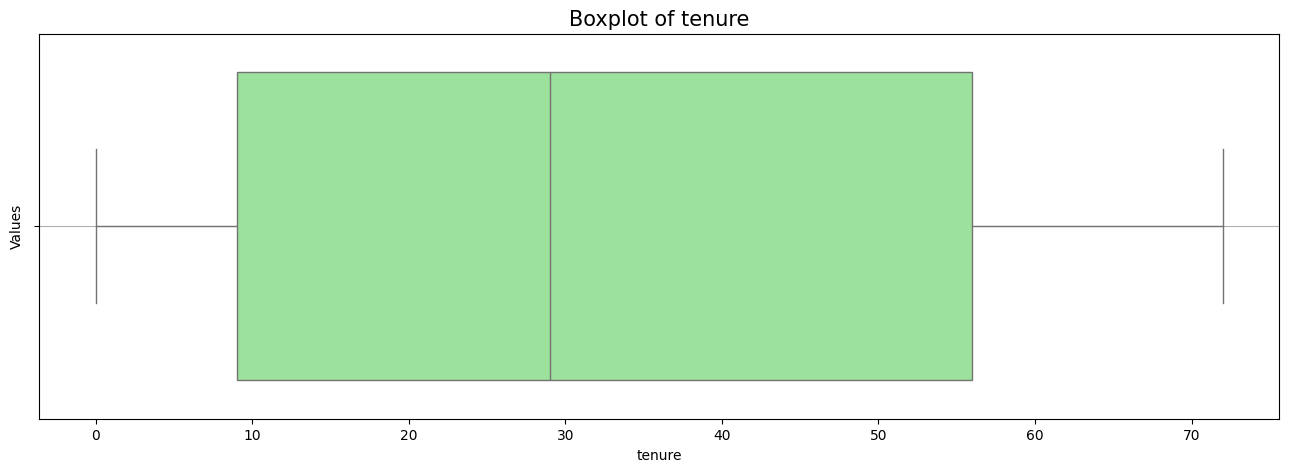

In [34]:
# Create a histogram for tenure
plt.figure(figsize=(8, 6))
plt.hist(data_train['tenure'], bins=10, color='skyblue', edgecolor='black')
plt.title('Histogram of tenure')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Create a boxplot for tenure
plt.figure(figsize=(16, 5))
sns.boxplot(data_train['tenure'], color='lightgreen', orient='h')
plt.title('Boxplot of tenure', fontsize=15)
plt.ylabel('Values')
plt.grid(True, axis='y')
plt.show()



# Observations
The histogram shows a bimodal distribution with two distinct peaks each representing two different groups with higher frequencies.

The box-plot shows that minimum tenure is 0 and maximum 72 with a median of 29

there are no outliers

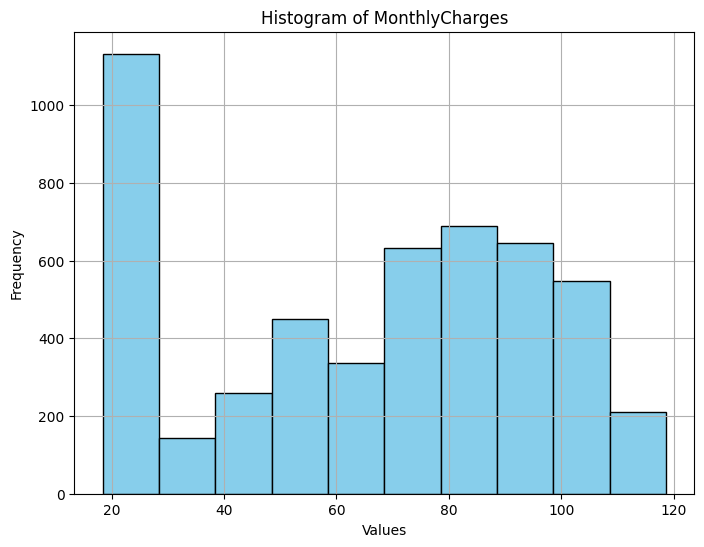

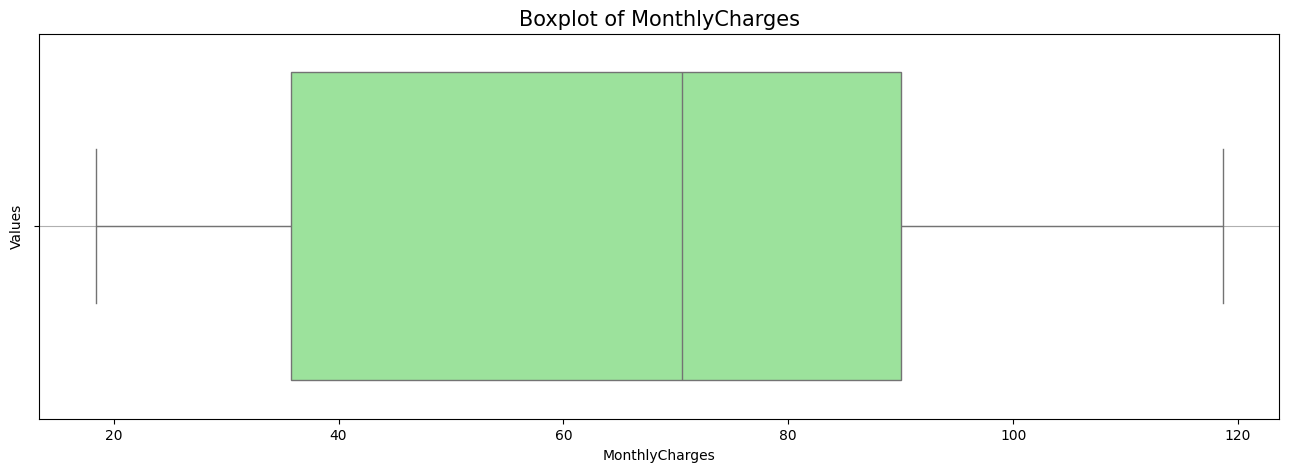

In [35]:
# Create a histogram for MonthlyCharges
plt.figure(figsize=(8, 6))
plt.hist(data_train['MonthlyCharges'], bins=10, color='skyblue', edgecolor='black')
plt.title('Histogram of MonthlyCharges')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Create a boxplot for MonthlyCharges
plt.figure(figsize=(16, 5))
sns.boxplot(data_train['MonthlyCharges'], color='lightgreen', orient='h')
plt.title('Boxplot of MonthlyCharges', fontsize=15)
plt.ylabel('Values')
plt.grid(True, axis='y')
plt.show()

# Observations

The histogram shows a unimodal distribution with one distinct peak showing a distinct group with a high frequency.

from the boxplot most of the values fall between the median of 70.9 and a minimum of 18.4

there are no outliers

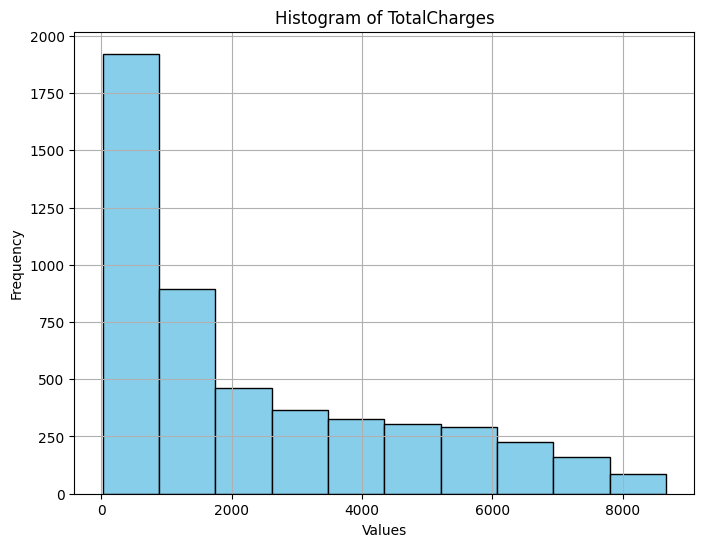

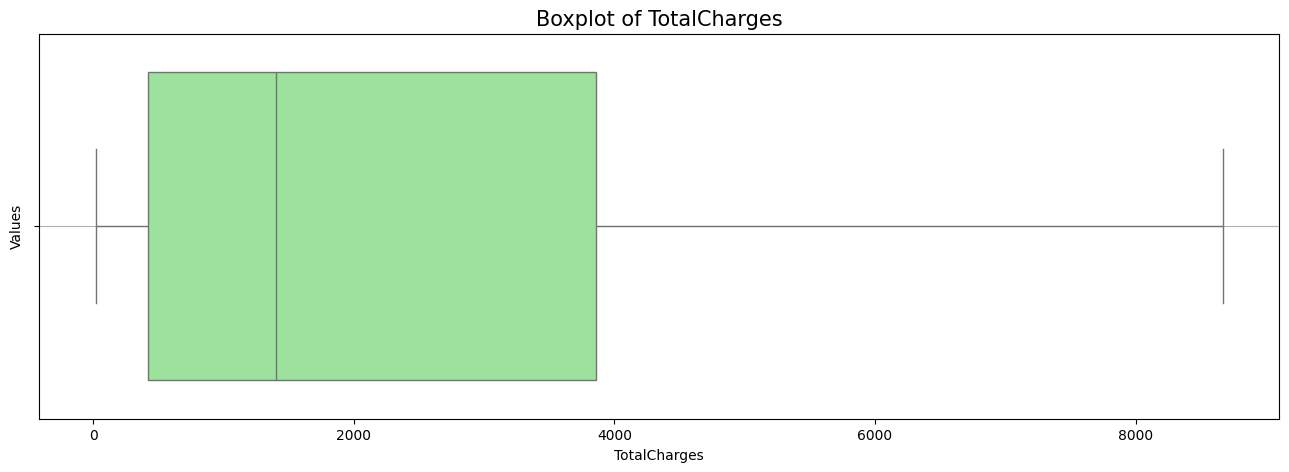

In [36]:
# Create a histogram for TotalCharges
plt.figure(figsize=(8, 6))
plt.hist(data_train['TotalCharges'], bins=10, color='skyblue', edgecolor='black')
plt.title('Histogram of TotalCharges')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Create a boxplot for TotalCharges
plt.figure(figsize=(16, 5))
sns.boxplot(data_train['TotalCharges'], color='lightgreen', orient='h')
plt.title('Boxplot of TotalCharges', fontsize=15)
plt.ylabel('Values')
plt.grid(True, axis='y')
plt.show()

# Observations
The histogram shows that the data is rightly-skewed indicating that most data values are on the left side.

from the boxplot its clear that there is large range between the median which is 1404 and maximum of 8564

## Analyzing the Categorical Variables

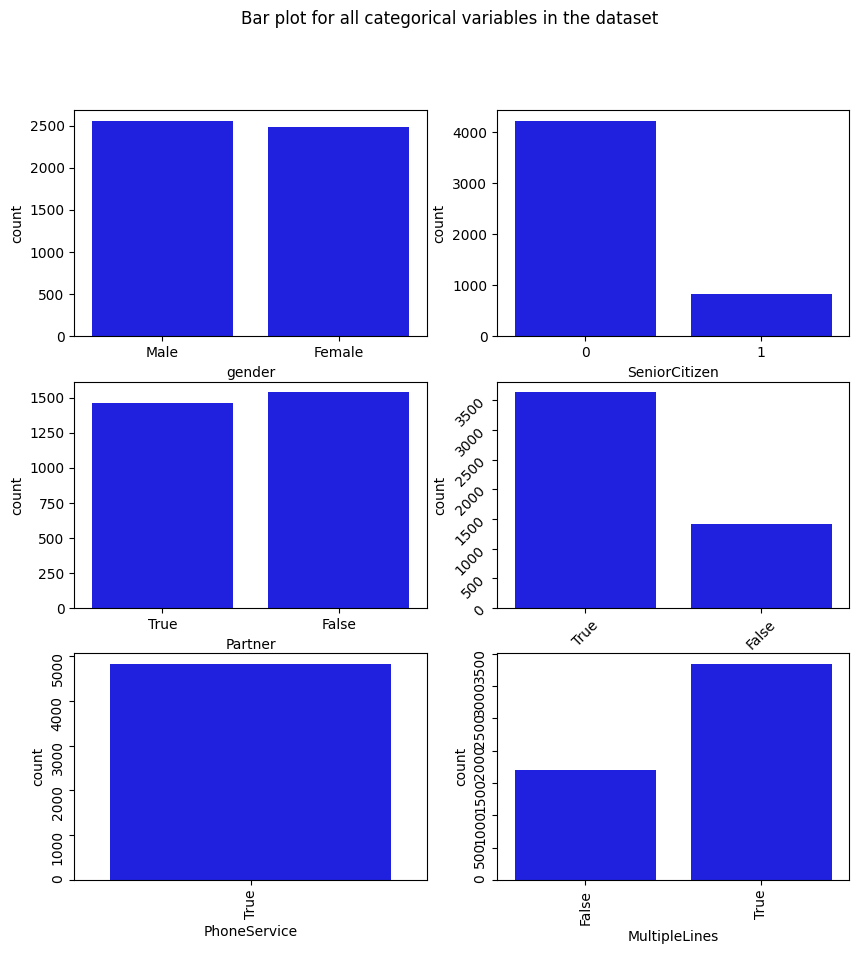

In [37]:
fig, axes = plt.subplots(3, 2, figsize = (10, 10))
fig.suptitle('Bar plot for all categorical variables in the dataset')
sns.countplot(ax = axes[0, 0], x = 'gender', data = data_train, color = 'blue', 
              order = data_train['gender'].value_counts().index);
sns.countplot(ax = axes[0, 1], x = 'SeniorCitizen', data = data_train, color = 'blue', 
              order = data_train['SeniorCitizen'].value_counts().index);
sns.countplot(ax = axes[1, 0], x = 'Partner', data = data_set1, color = 'blue', 
              order = data_train['Partner'].value_counts().index);
sns.countplot(ax = axes[1, 1], x = 'Dependents', data = data_train, color = 'blue', 
              order = data_train['Dependents'].value_counts().index);
sns.countplot(ax = axes[2, 0], x = 'PhoneService', data = data_train, color = 'blue', 
              order = data_train['PhoneService'].head(20).value_counts().index);
sns.countplot(ax = axes[2, 1], x = 'MultipleLines', data = data_train, color = 'blue', 
              order = data_train['MultipleLines'].head(20).value_counts().index);
axes[1][1].tick_params(labelrotation=45);
axes[2][0].tick_params(labelrotation=90);
axes[2][1].tick_params(labelrotation=90);

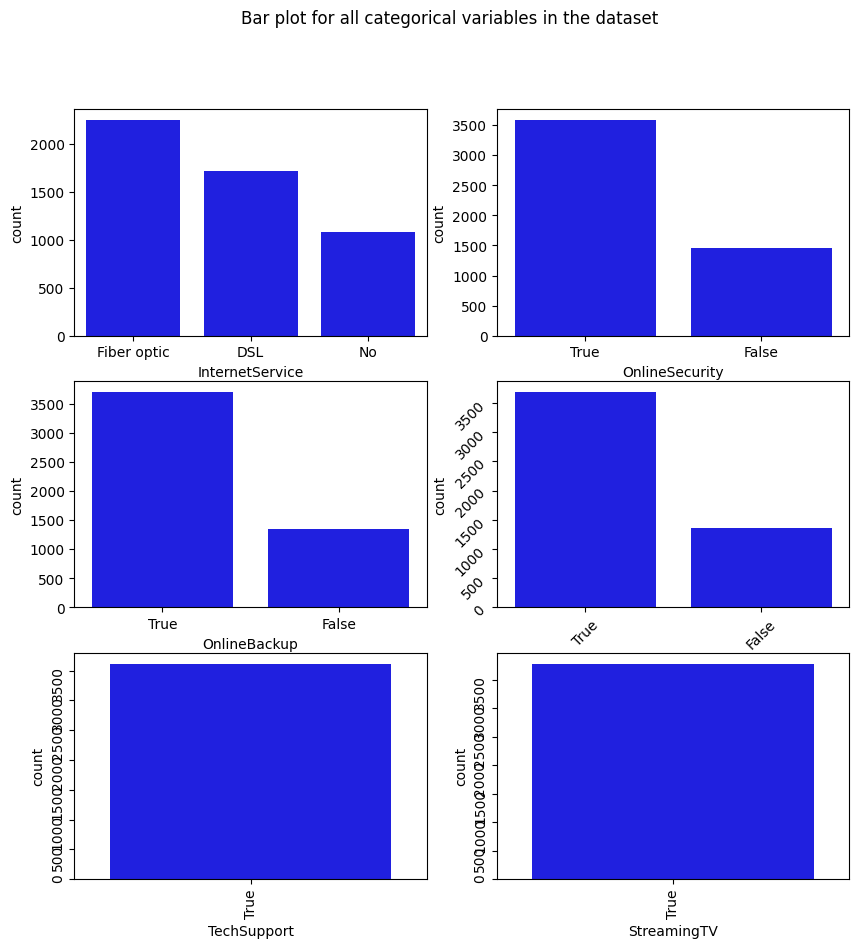

In [38]:
fig, axes = plt.subplots(3, 2, figsize = (10, 10))
fig.suptitle('Bar plot for all categorical variables in the dataset')
sns.countplot(ax = axes[0, 0], x = 'InternetService', data = data_train, color = 'blue', 
              order = data_train['InternetService'].value_counts().index);
sns.countplot(ax = axes[0, 1], x = 'OnlineSecurity', data = data_train, color = 'blue', 
              order = data_train['OnlineSecurity'].value_counts().index);
sns.countplot(ax = axes[1, 0], x = 'OnlineBackup', data = data_train, color = 'blue', 
              order = data_train['OnlineBackup'].value_counts().index);
sns.countplot(ax = axes[1, 1], x = 'DeviceProtection', data = data_train, color = 'blue', 
              order = data_train['DeviceProtection'].value_counts().index);
sns.countplot(ax = axes[2, 0], x = 'TechSupport', data = data_train, color = 'blue', 
              order = data_train['TechSupport'].head(20).value_counts().index);
sns.countplot(ax = axes[2, 1], x = 'StreamingTV', data = data_train, color = 'blue', 
              order = data_train['StreamingTV'].head(20).value_counts().index);
axes[1][1].tick_params(labelrotation=45);
axes[2][0].tick_params(labelrotation=90);
axes[2][1].tick_params(labelrotation=90);

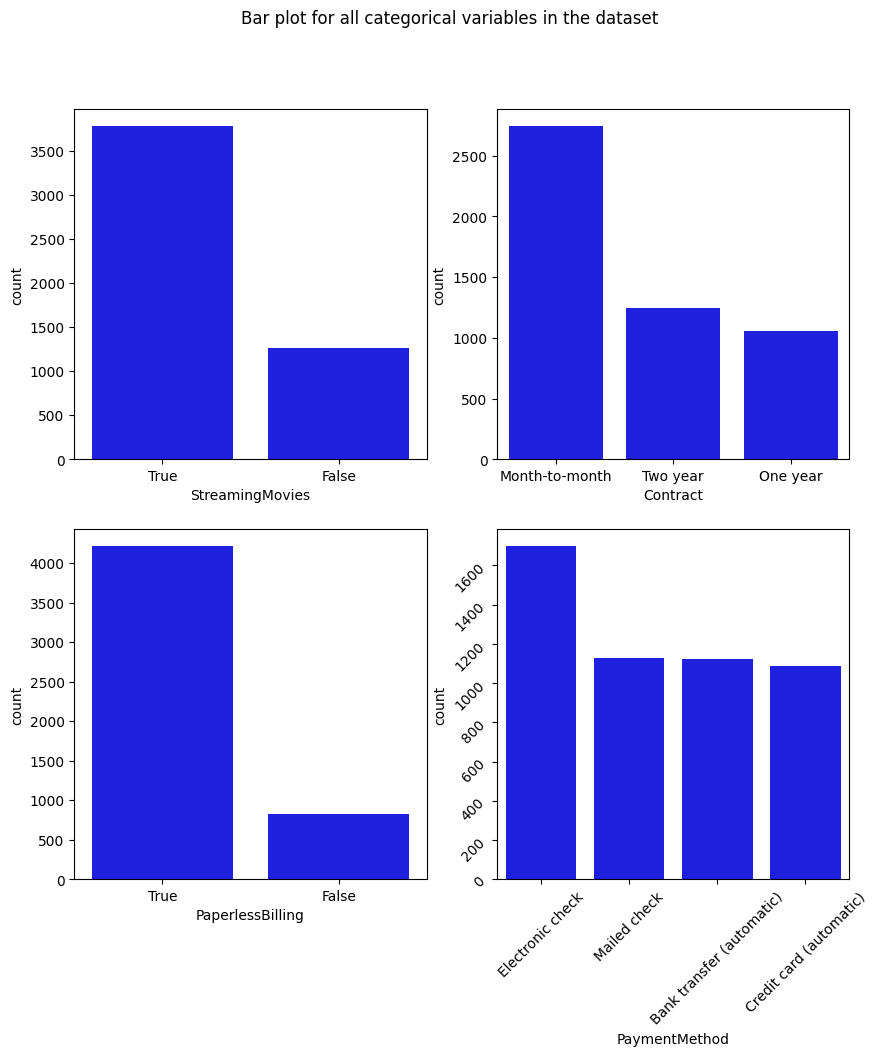

In [39]:
fig, axes = plt.subplots(2, 2, figsize = (10, 10))
fig.suptitle('Bar plot for all categorical variables in the dataset')
sns.countplot(ax = axes[0, 0], x = 'StreamingMovies', data = data_train, color = 'blue', 
              order = data_train['StreamingMovies'].value_counts().index);
sns.countplot(ax = axes[0, 1], x = 'Contract', data = data_train, color = 'blue', 
              order = data_train['Contract'].value_counts().index);
sns.countplot(ax = axes[1, 0], x = 'PaperlessBilling', data = data_train, color = 'blue', 
              order = data_train['PaperlessBilling'].value_counts().index);
sns.countplot(ax = axes[1, 1], x = 'PaymentMethod', data = data_train, color = 'blue', 
              order = data_train['PaymentMethod'].value_counts().index);

axes[1][1].tick_params(labelrotation=45);


## Multivariate Analysis

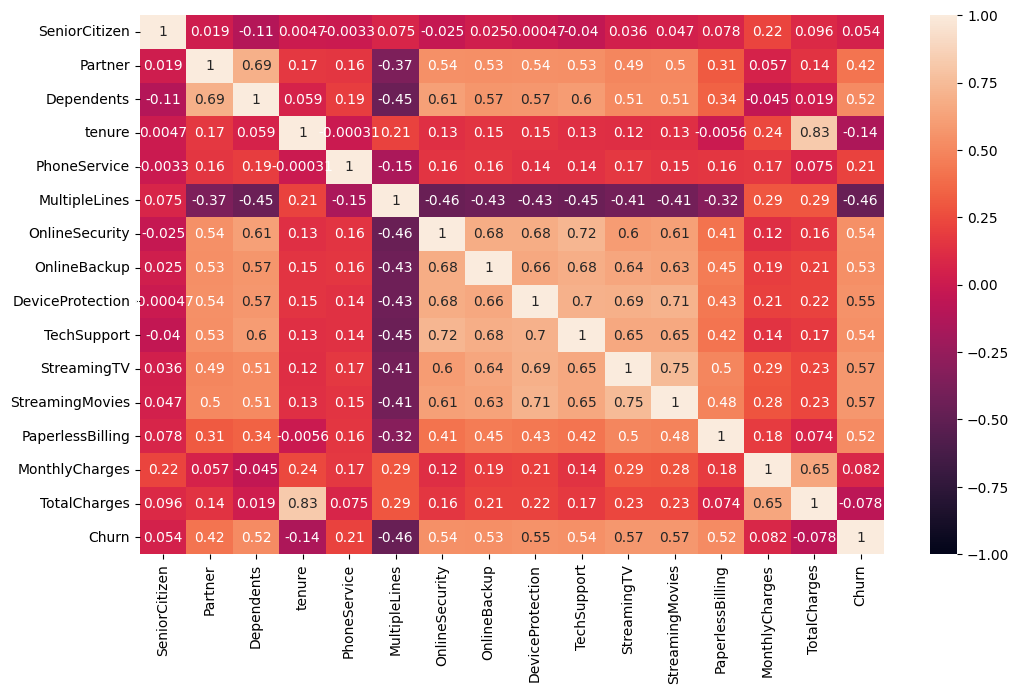

In [40]:
plt.figure(figsize=(12, 7))
sns.heatmap(data_train.drop(['customerID', 'gender', 'Contract', 'PaymentMethod', 'InternetService'],axis=1).corr(), annot = True, vmin = -1, vmax = 1)
plt.show()

# Observation
Each Cell shows the correlation between two variables

There is a strong positive relationship between tenure and total charges

There is also a fairly strong positive correlation between tenure and Multiplines, OnlineSecurity, OnlineBackup, DeviceProtection, Techsupport, StreamingTV and StreamingMovies

There is a fairly weak negative correlation between multiplines and these variables; OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, PaperlessBilling, Dependents and Partner

There is also a positive correlation between Churn and these variables; Dependents, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies and PaperlessBilling

There is a strong positive relationship between MonthlyCharges and StreamingTV,StreamingMovies and TotalCharges.

StreamingMovies, StreamingTV, TechSupport, DeviceProtection, OnlineBackup and OnlineSecurity have positive correlation with both Partner and Dependents variables.

## Answering Analytical Questions

1. What is the total Churn rate?

<Axes: ylabel='count'>

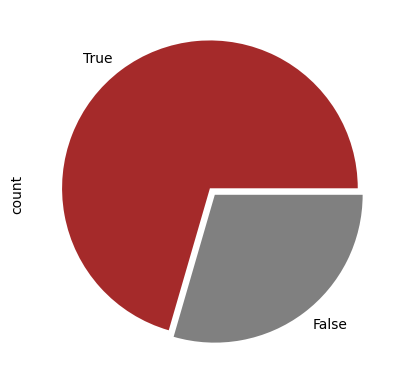

In [41]:
data_train["Churn"].value_counts().plot.pie(explode=(0.05,0.005), colors=['brown', "grey"])

2. What is the churn rate among different demographic groups (e.g., gender, SeniorCitizen status)?

In [42]:
data_train.groupby("gender")["Churn"].value_counts()

gender  Churn
Female  True     1740
        False     744
Male    True     1815
        False     743
Name: count, dtype: int64

<Axes: xlabel='gender', ylabel='count'>

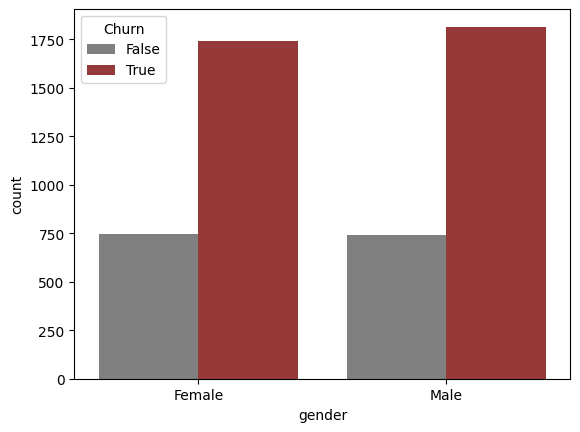

In [43]:
sns.countplot(data=data_train, x="gender", hue="Churn", palette={False:"grey", True:"Brown"})

3. How does the citizen level affect their likelihood to churn?

<Axes: xlabel='SeniorCitizen', ylabel='count'>

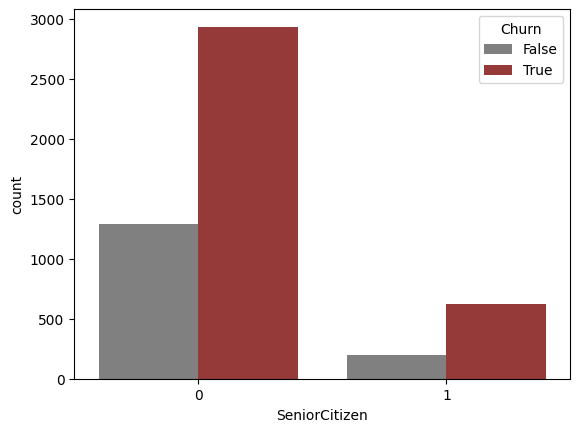

In [44]:
sns.countplot(data=data_train, x="SeniorCitizen", hue="Churn",palette={False:"grey", True:"Brown"})

4. Are customers with Phone Services more likely to churn?

<Axes: xlabel='PhoneService', ylabel='count'>

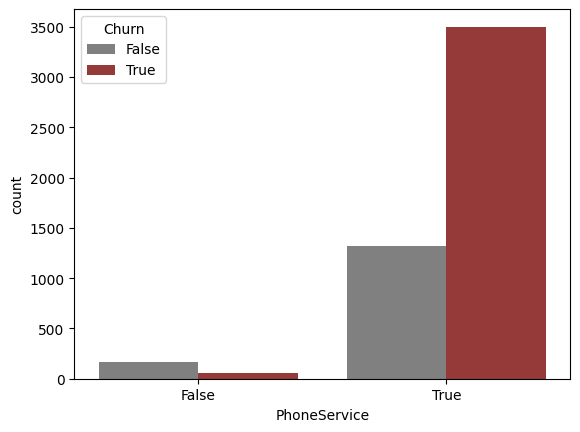

In [45]:
sns.countplot(data=data_train, x="PhoneService", hue="Churn",palette={False:"grey", True:"Brown"})

5. How do contract terms (e.g., Contract length, PaperlessBilling) influence churn?

<Axes: xlabel='Contract', ylabel='count'>

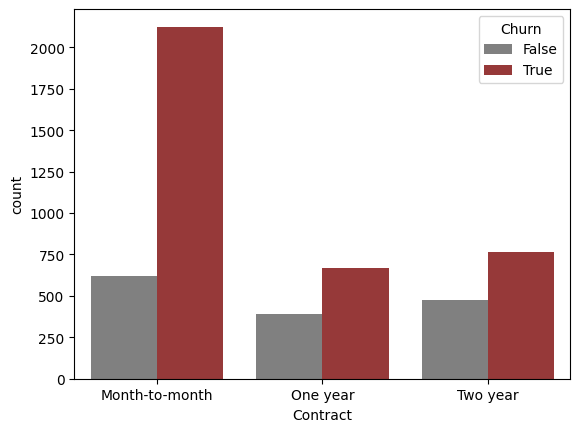

In [46]:
sns.countplot(data=data_train, x="Contract", hue="Churn",palette={False:"grey", True:"Brown"})

<Axes: xlabel='PaperlessBilling', ylabel='count'>

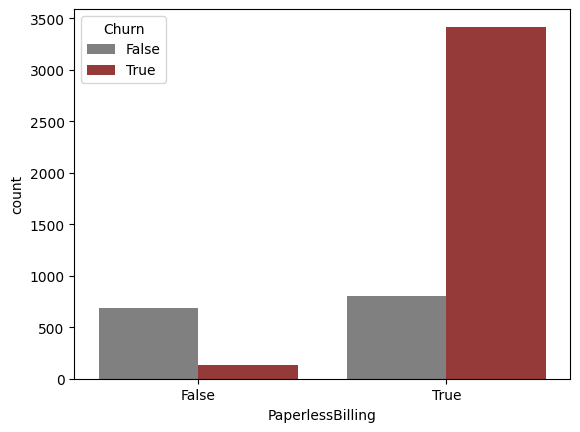

In [47]:
sns.countplot(data=data_train, x="PaperlessBilling", hue="Churn",palette={False:"grey", True:"Brown"})

6. What role do payment methods play in customer churn?

([0, 1, 2, 3],
 [Text(0, 0, 'Electronic check'),
  Text(1, 0, 'Mailed check'),
  Text(2, 0, 'Bank transfer (automatic)'),
  Text(3, 0, 'Credit card (automatic)')])

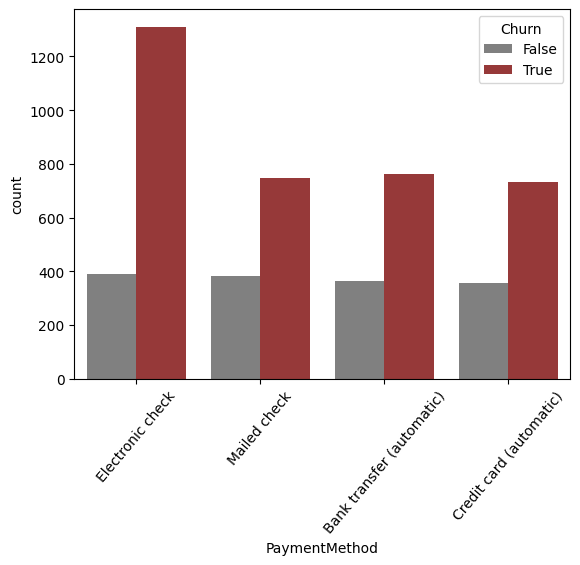

In [48]:
sns.countplot(data=data_train, x="PaymentMethod", hue="Churn",palette={False:"grey", True:"Brown"})
plt.xticks(rotation=50)

## Hypothesis Testing

Chi square test will be used for hypothesis testing. The chi-square test helps you assess whether there is evidence to reject the null hypothesis that the two categorical variables are independent. If the p-value is low, you can conclude that there is a significant association between the variables. If the p-value is high, you fail to reject the null hypothesis, suggesting that there is no significant association.

In [49]:
# Creating a contigency table
contingency_table = pd.crosstab(data_train['Contract'], data_train['Churn'])

# Perform the chi-square test
chi2, p, _, _ = chi2_contingency(contingency_table)

# printing results of the p-value
print("P-value:", p)

# printing Results of the t-test
# having alpha to be 0.05(level of significance)
alpha = 0.05
if p < alpha:
    print("Reject the null hypothesis - There is a significant relationship between Contract terms and Churn.")
else:
    print("Fail to reject the null hypothesis - There is no significant relationship between Contract terms and Churn.")

P-value: 8.701242601439004e-31
Reject the null hypothesis - There is a significant relationship between Contract terms and Churn.


Observation
- We can see from the results that our p-value is wayy lesser than the significance level. Hence we can conclude that the null     hypothesis we have is less significant and hence we have enough confidence to reject the null hypothesis.
- This means our alternative hypothesis is actually true (There is a relationship between Contracts and Churn)

## Data Preparation

In [50]:
# Check to see if the target variable is balanced

churn_distro = data_train['Churn'].value_counts().rename('Total').reset_index()
churn_distro

,Churn,Total
0,True,3555
1,False,1487


In [51]:
churn_distro['Ratio'] = churn_distro['Total'].apply(lambda x: round (x/churn_distro['Total'].sum() * 100), 2)
churn_distro

,Churn,Total,Ratio
0,True,3555,71
1,False,1487,29


from the result we can see that the train dataset is mildly imbalanced

### Split dataset training and evaluation

In [52]:
X = data_train.drop(['customerID', 'Churn'], axis=1)
y = data_train['Churn']



In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7,  random_state=42, stratify=y)

### Label Encoding

In [54]:
encoder = LabelEncoder()

y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

### Prepare Pipeline

In [55]:
numeric_columns = X.select_dtypes('number').columns
numeric_columns

Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')

In [56]:
categorical_columns = X.drop(numeric_columns, axis=1).columns
categorical_columns

Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object')

In [61]:
numeric_pipeline = Pipeline(steps=[
    ("num_imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ("cat_imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder())
])

preprocessor = ColumnTransformer(transformers=[
    ("num_pipeline", numeric_pipeline, numeric_columns),
    ("cat_pipeline", categorical_pipeline, categorical_columns)
])


## Modelling

In [66]:
models = [
    ("Logistic Regression", LogisticRegression(random_state=42)),
    ("Decision Tree", DecisionTreeClassifier(random_state=42)),
    ("Random Forest", RandomForestClassifier(random_state=42)),
    ("XGBoost", XGBClassifier(random_state=42)),
]

In [67]:
all_pipeline={}

for model_name, classifier in models:

    final_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", classifier)
    ])

    # fit data to pipeline
    final_pipeline.fit(X_train, y_train_encoded)

    all_pipeline[model_name] = final_pipeline
    print(f"{model_name} model is trained")

Logistic Regression model is trained
Decision Tree model is trained
Random Forest model is trained
XGBoost model is trained


In [68]:
report_data = []

for model_name, pipeline in all_pipeline.items():
    # Predict the target values
    y_pred = pipeline.predict(X_test)
    
    # Get the classification report
    report = classification_report(y_test_encoded, y_pred, output_dict=True)
    
    # Store the model name and report data
    report_data.append({"model": model_name, "report": report})


In [69]:
report_data

[{'model': 'Logistic Regression',
  'report': {'0': {'precision': 0.7775510204081633,
    'recall': 0.8542600896860987,
    'f1-score': 0.8141025641025641,
    'support': 446.0},
   '1': {'precision': 0.9364613880742912,
    'recall': 0.8978444236176195,
    'f1-score': 0.9167464114832536,
    'support': 1067.0},
   'accuracy': 0.8849966953073364,
   'macro avg': {'precision': 0.8570062042412272,
    'recall': 0.8760522566518592,
    'f1-score': 0.8654244877929089,
    'support': 1513.0},
   'weighted avg': {'precision': 0.8896180146578385,
    'recall': 0.8849966953073364,
    'f1-score': 0.8864892033327001,
    'support': 1513.0}}},
 {'model': 'Decision Tree',
  'report': {'0': {'precision': 0.785234899328859,
    'recall': 0.7869955156950673,
    'f1-score': 0.786114221724524,
    'support': 446.0},
   '1': {'precision': 0.9108818011257036,
    'recall': 0.9100281162136832,
    'f1-score': 0.9104547585560244,
    'support': 1067.0},
   'accuracy': 0.8737607402511567,
   'macro avg':

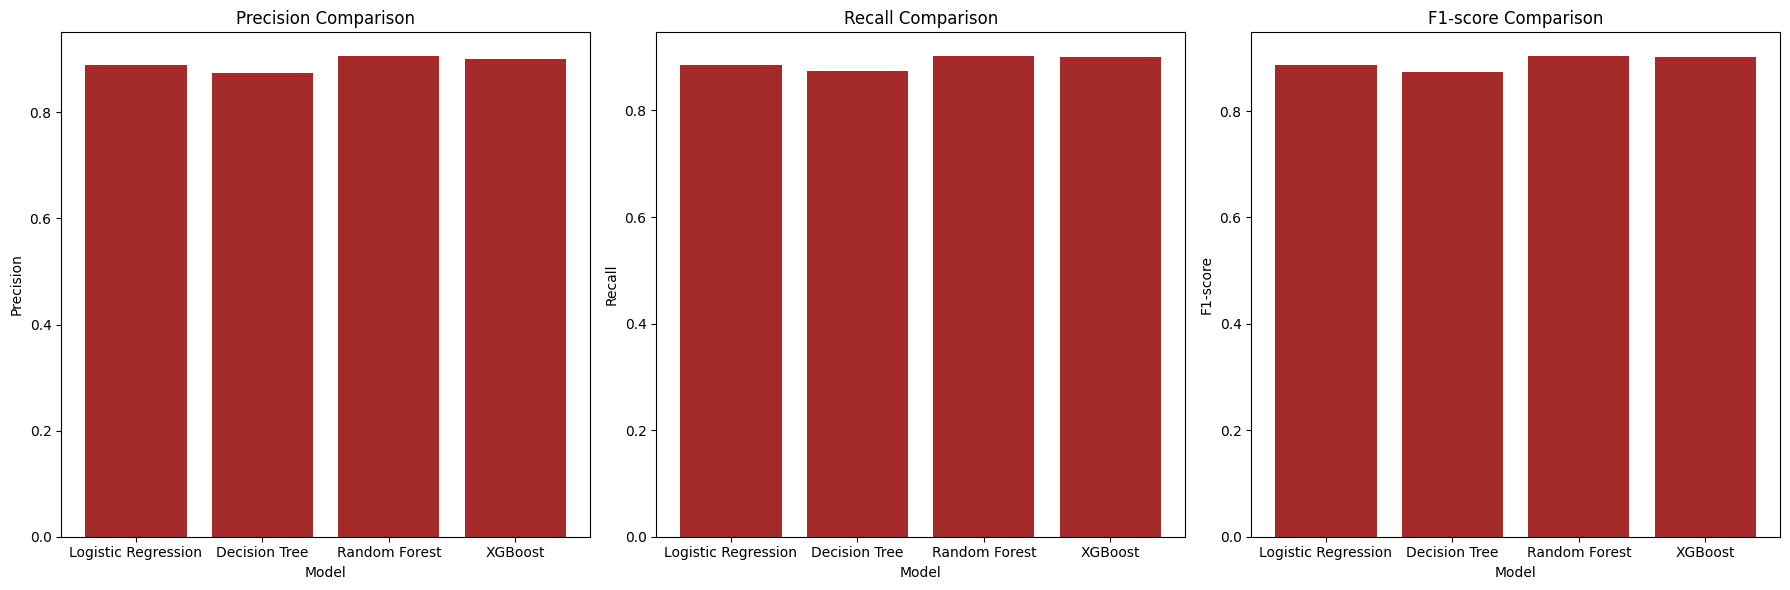

In [70]:
# Plotting the precision, recall, and f1-score for each model and comparing
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

for i, metric in enumerate(["precision", "recall", "f1-score"]):
    ax[i].bar([data["model"] for data in report_data], [data["report"]["weighted avg"][metric] for data in report_data], color="brown")
    ax[i].set_title(f"{metric.capitalize()} Comparison")
    ax[i].set_xlabel("Model")
    ax[i].set_ylabel(metric.capitalize())

plt.tight_layout()
plt.show()
